In [2]:
import sys
sys.path.append("../")

In [3]:
from src.models.incrementals.components import *
import torch
from torch.utils import data
from torchvision import utils as vutils

In [4]:
source_encoder = VGGEncoder()
source_generator = VGGSourceGenerator(z_dim=128, num_features=32768)
classifier = Decoder(34, 512, 128)
source_encoder.load_state_dict(torch.load('../weights/source_encoder.path'))
classifier.load_state_dict(torch.load('../weights/classifier.path'))
source_generator.load_state_dict(torch.load('../weights/source_generator.path'))


<All keys matched successfully>

In [5]:
from src.datasets.cityscapes import CityscapesDataset

In [6]:
cityscapes_dataset = CityscapesDataset(
         cityscapes_data_path='/data/ubuntu/cityscapes/leftImg8bit',
         cityscapes_meta_path='/data/ubuntu/cityscapes/gtFine',
         train_city_list = ["zurich/", "weimar/", "ulm/"]
         )
data_loader = data.DataLoader(
    cityscapes_dataset, 12, shuffle=True)
all_labels = [i for i in range(34)]

In [7]:
data_loader.dataset.set_cities(["zurich/", "weimar/", "ulm/"])
source_generator.eval()
source_encoder.eval()
classifier.eval()
data_loader.dataset.train()
device = torch.device('cuda:2')
source_generator.to(device)
source_encoder.to(device)
classifier.to(device)
target_preds_batch = []
source_preds_batch = []
target_labels_batch = []
target_images_batch = []
target_features_batch = []
with torch.no_grad():
    for i, (target_data, target_labels) in enumerate(data_loader):
        batch_size = target_data.size(0)
        target_data = target_data.to(device)
        target_labels = target_labels.to(device)
        source_features = source_encoder(target_data)
        break
        # target_features = ((target_features - target_features.mean()) / target_features.std()) * std + mean
        # target_features = transfer.forward(target_features, source_features)
        # target_preds = classifier(target_features).detach()
        # source_preds_batch.append(source_preds.cpu())
        # target_preds_batch.append(target_preds.cpu())
        # target_images_batch.append(target_data.cpu())
        # target_labels_batch.append(target_labels.cpu())

In [8]:
print(source_features.mean())
print(source_features.std())

tensor(16.2593, device='cuda:2')
tensor(37.0308, device='cuda:2')


In [9]:
source_features = ((source_features[0] - source_features[0].mean()) / source_features[0].std()) * source_features.std() + source_features.mean()

In [17]:
from sklearn.metrics import accuracy_score, jaccard_score
from tqdm import tqdm
from adain import AdaINTransfer, AdaLNTransfer
from kl import KLDivergence

div = KLDivergence()
transfer = AdaINTransfer()
mean = source_features.mean()
std = source_features.std()

target_city_list = ["stuttgart/", "strasbourg/", "monchengladbach/", "krefeld/", "hanover/", "hamburg/", "erfurt/", "dusseldorf/", 
                    "darmstadt/", "cologne/", "bremen/", "bochum/", "aachen/","frankfurt/", "munster/", "lindau/", "berlin", "bielefeld",
                    "bonn", "leverkusen", "mainz", "munich"]
for city in target_city_list:
    data_loader.dataset.set_cities([city])
    source_generator.eval()
    source_encoder.eval()
    classifier.eval()
    data_loader.dataset.eval()
    source_generator.to(device)
    source_encoder.to(device)
    classifier.to(device)
    target_preds_batch = []
    source_preds_batch = []
    target_labels_batch = []
    target_images_batch = []
    target_features_batch = []
    with torch.no_grad():
        for i, (target_data, target_labels) in enumerate(data_loader):
            batch_size = target_data.size(0)
            target_data = target_data.to(device)
            target_labels = target_labels.to(device)
            target_features = source_encoder(target_data)
            target_features_batch.append(target_features.cpu())

            b = target_features.size(0)
            source_preds = classifier(target_features).detach()
            target_features = ((target_features - target_features.mean()) / target_features.std()) * source_features.std() + source_features.mean()
            # target_features = transfer.forward(target_features, source_features.unsqueeze(0))
            target_preds = classifier(target_features).detach()
            source_preds_batch.append(source_preds.cpu())
            target_preds_batch.append(target_preds.cpu())
            target_images_batch.append(target_data.cpu())
            target_labels_batch.append(target_labels.cpu())

    target_preds_batch = torch.cat(target_preds_batch, dim=0).max(1)[1].view(-1).numpy()
    source_preds_batch = torch.cat(source_preds_batch, dim=0).max(1)[1].view(-1).numpy()
    
    target_labels_batch = torch.cat(target_labels_batch, dim=0).view(-1).numpy()
    target_features = torch.cat(target_features_batch, dim=0).mean(0)
    target_mean = target_features.mean()
    target_std = target_features.std()
    
    kl = div(source_features.squeeze(), target_features)
    print(kl)
    adabn_iou = jaccard_score(target_preds_batch, target_labels_batch, labels=all_labels, average=None)[1:].mean()
    adabn_accuracy = accuracy_score(target_preds_batch, target_labels_batch)
    iou = jaccard_score(source_preds_batch, target_labels_batch, labels=all_labels, average=None)[1:].mean()
    accuracy = accuracy_score(source_preds_batch, target_labels_batch)
    print(city)
    print(adabn_iou)
    print(iou)
    print(adabn_accuracy)
    print(accuracy)

tensor(0.0032, device='cuda:2')
stuttgart/
0.07433129363337959
0.07418992438559573
0.7205845579809073
0.7197761535644531
tensor(0.0043, device='cuda:2')
strasbourg/
0.056228468537964114
0.05605047518804678
0.5495704128317637
0.5480689479880136
tensor(0.0132, device='cuda:2')
monchengladbach/
0.054592961491569114
0.05437676642337437
0.5472342308531416
0.5453911639274435
tensor(0.0217, device='cuda:2')
krefeld/
0.07649044026515404
0.07631033609500656
0.636219833836411
0.6349592112531566
tensor(0.0073, device='cuda:2')
hanover/
0.05398518596309677
0.05381818194418773
0.5932091693488919
0.5918157149334343
tensor(0.0035, device='cuda:2')
hamburg/
0.060852319638315285
0.06072837216036489
0.5822123865927419
0.5812822772610572
tensor(0.0016, device='cuda:2')
erfurt/
0.07350628697091385
0.07341739723444973
0.6003356373638188
0.5990956157719324
tensor(0.0077, device='cuda:2')
dusseldorf/
0.061232620588183274
0.061107948845407906
0.6469457980194783
0.6463464244997879
tensor(0.0122, device='cuda:2

In [85]:
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplo

def denormalize(img):
    mean = torch.Tensor([0.485, 0.456, 0.406])
    std = torch.Tensor([0.229, 0.224, 0.225])
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
    return img

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

palette = [128, 64, 128, 244, 35, 232, 70, 70, 70, 102, 102, 156, 190, 153, 153, 153, 153, 153, 250, 170, 30,
           220, 220, 0, 107, 142, 35, 152, 251, 152, 70, 130, 180, 220, 20, 60, 255, 0, 0, 0, 0, 142, 0, 0, 70,
           0, 60, 100, 0, 80, 100, 0, 0, 230, 119, 11, 32]
def colorize_mask(mask):
    # mask: numpy array of the mask
    new_mask = Image.fromarray(mask.numpy().astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)
    new_mask = new_mask.convert('RGB')
    
    return transforms.functional.to_tensor(new_mask)

/home/ubuntu/.pyenv/versions/3.6.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


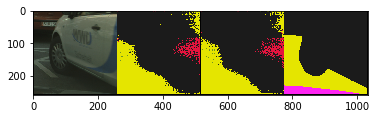

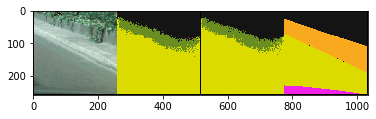

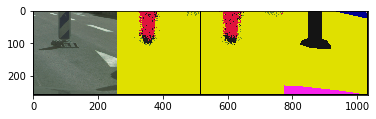

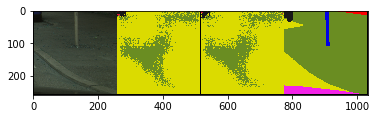

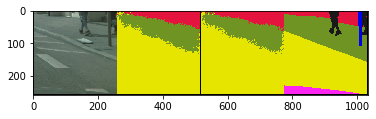

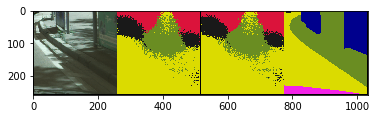

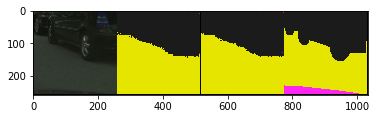

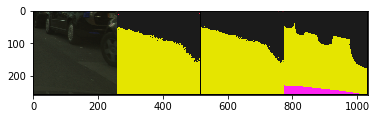

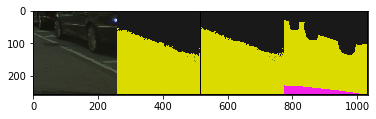

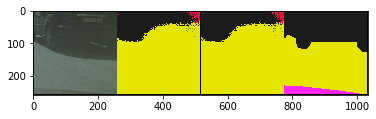

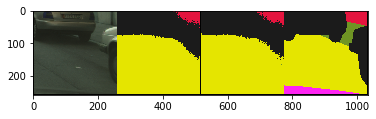

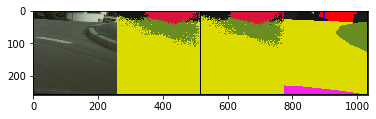

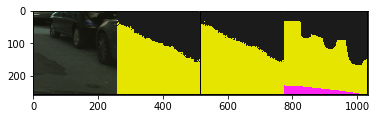

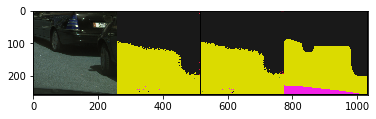

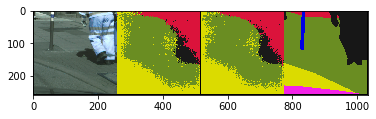

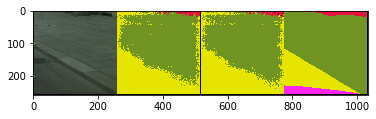

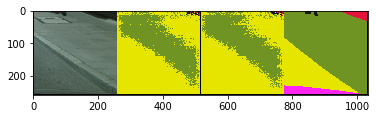

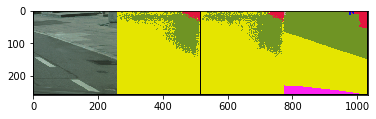

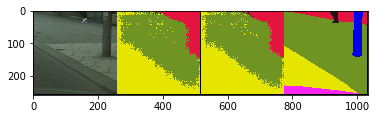

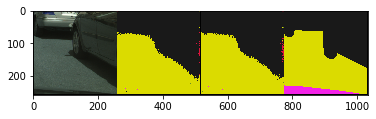

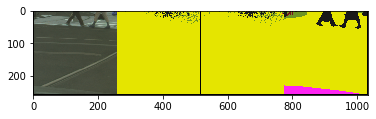

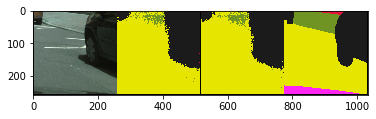

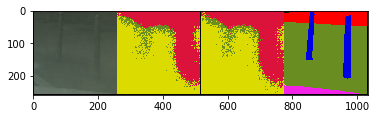

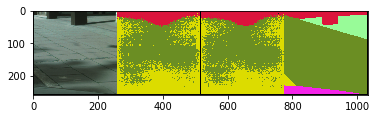

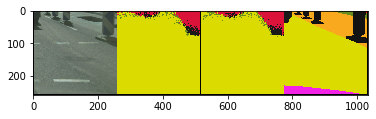

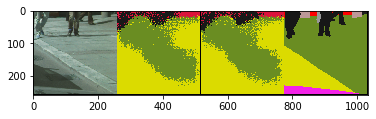

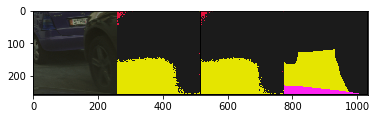

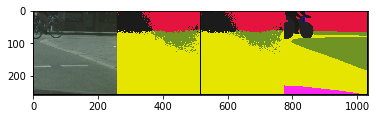

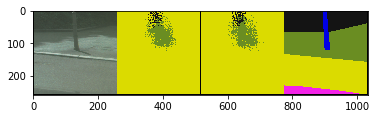

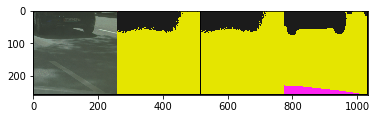

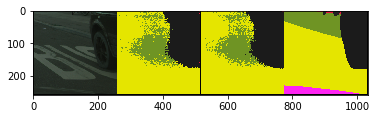

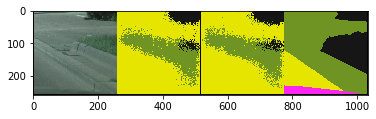

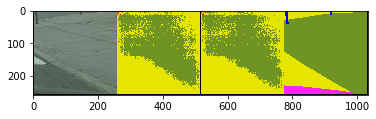

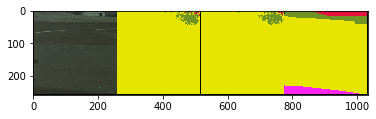

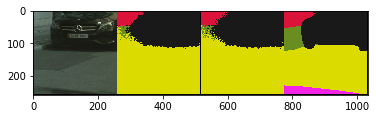

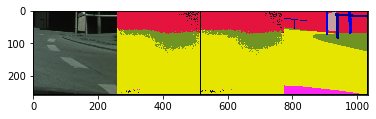

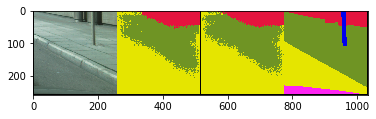

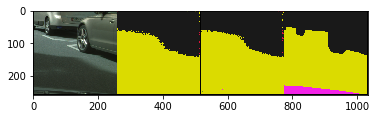

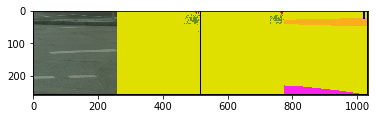

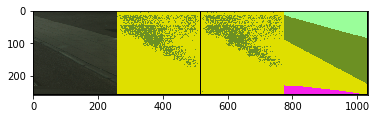

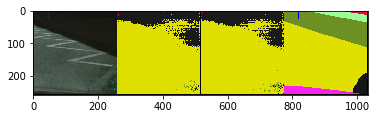

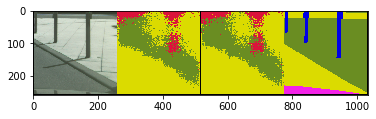

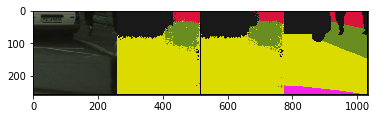

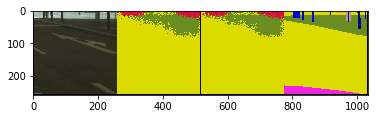

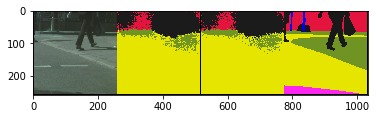

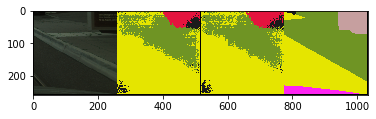

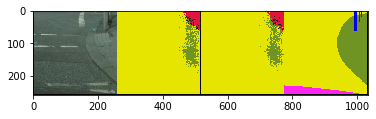

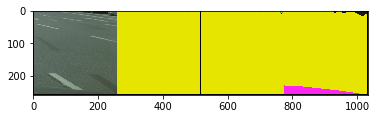

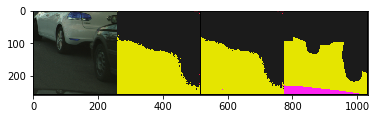

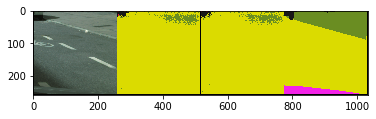

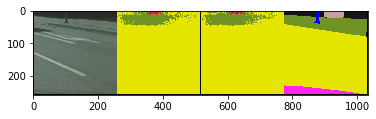

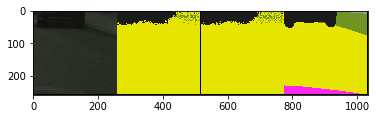

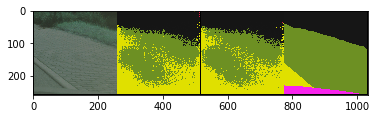

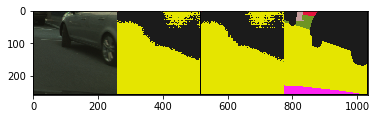

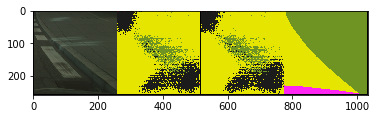

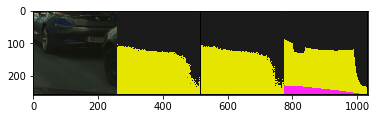

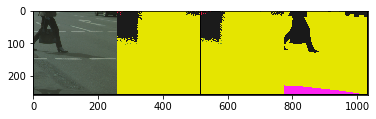

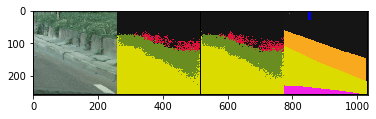

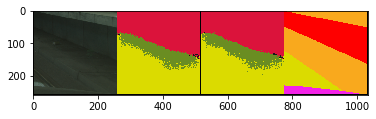

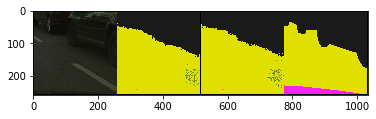

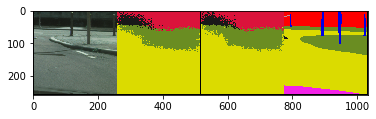

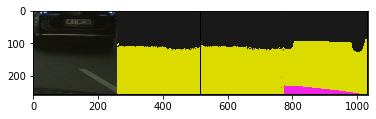

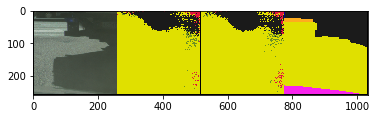

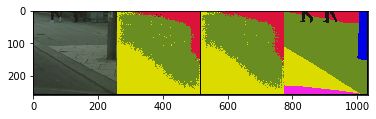

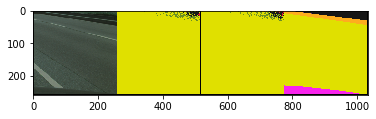

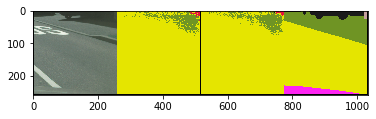

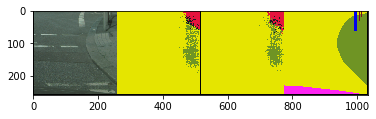

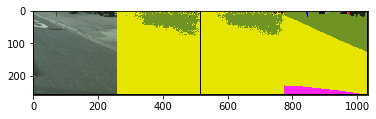

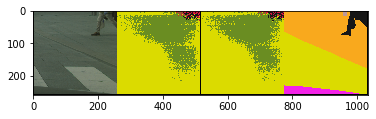

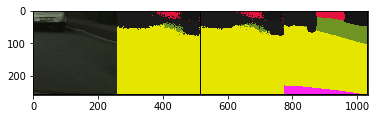

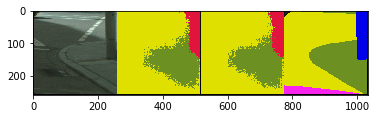

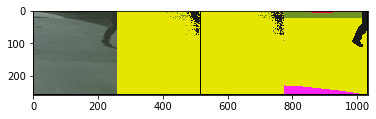

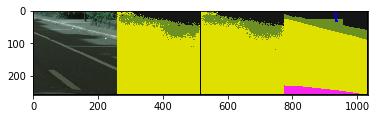

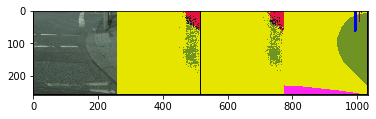

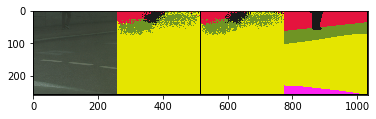

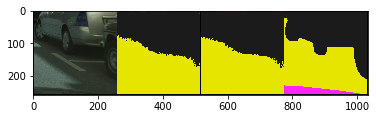

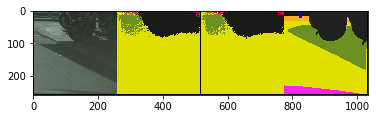

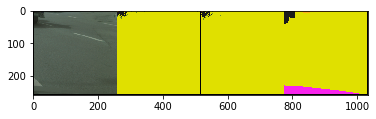

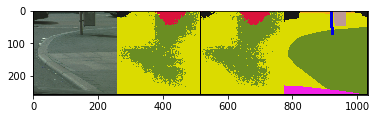

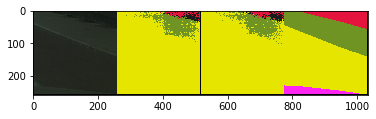

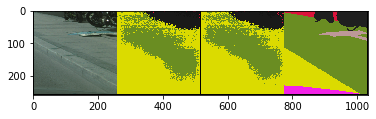

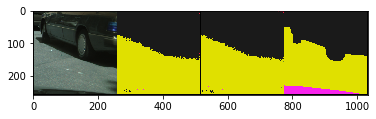

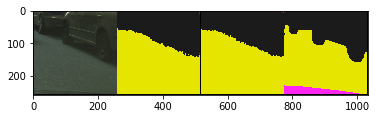

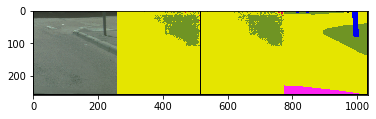

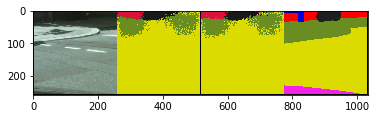

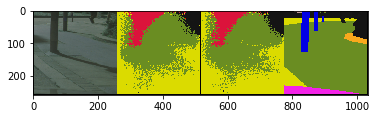

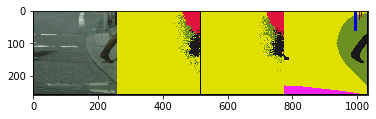

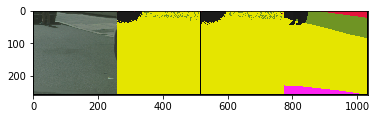

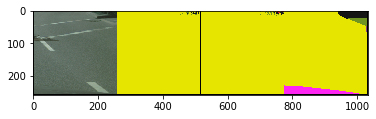

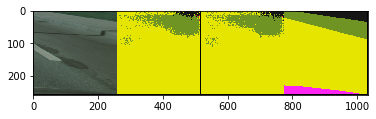

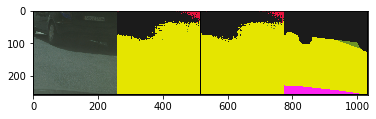

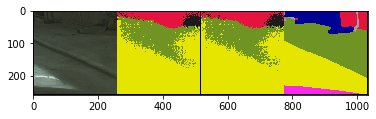

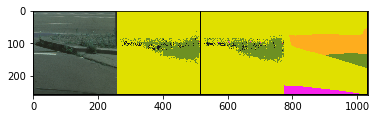

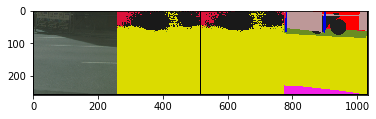

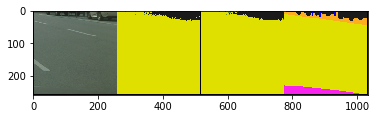

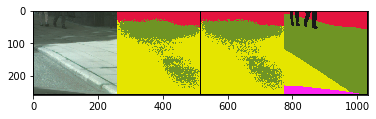

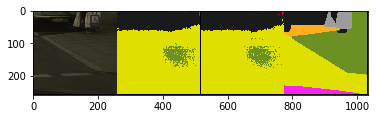

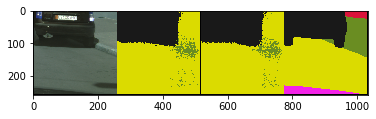

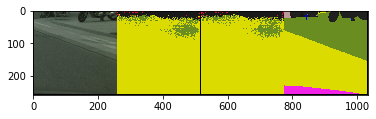

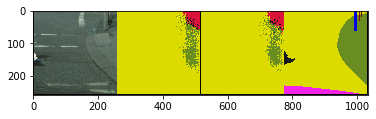

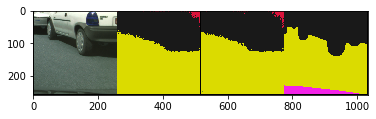

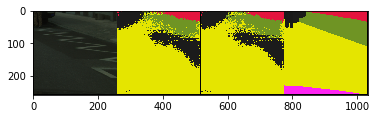

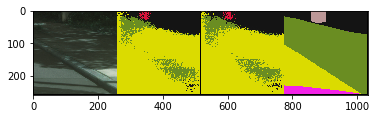

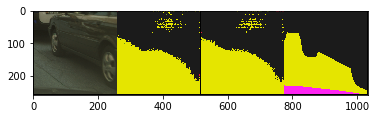

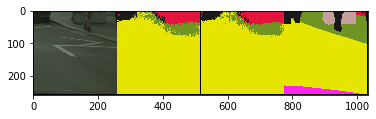

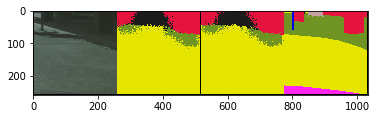

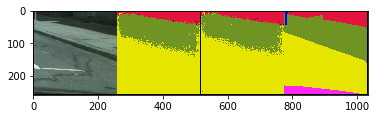

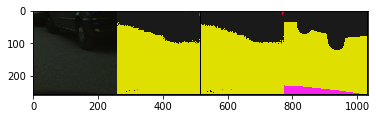

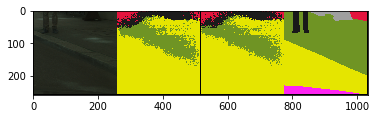

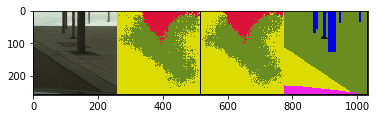

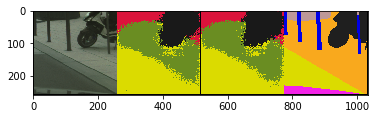

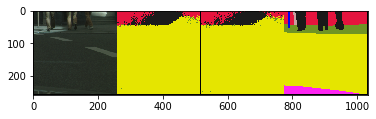

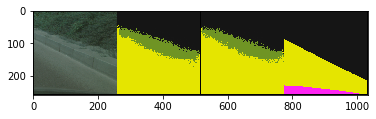

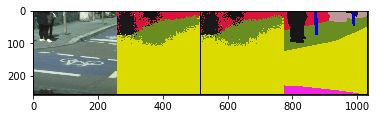

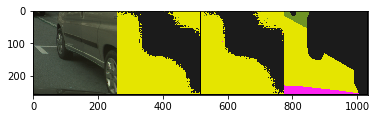

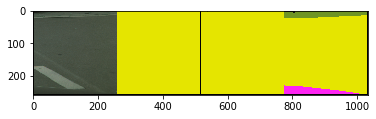

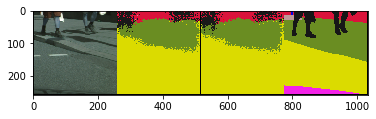

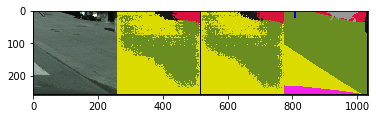

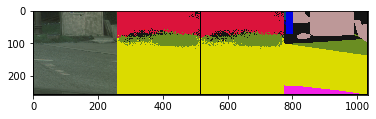

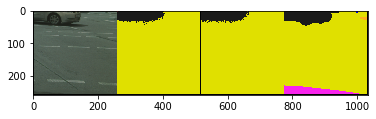

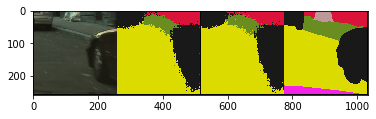

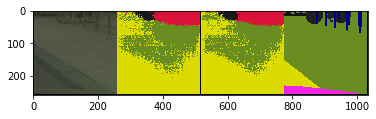

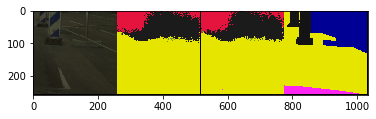

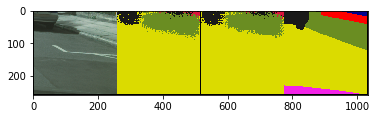

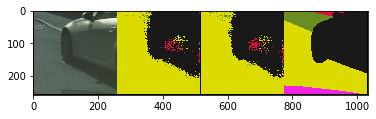

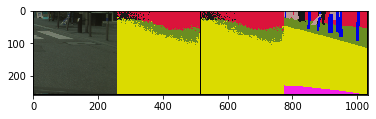

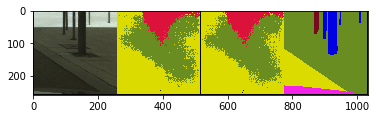

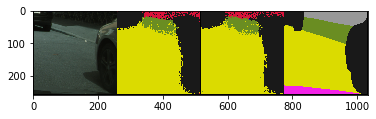

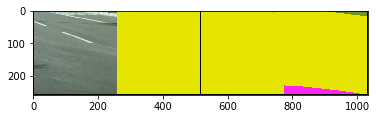

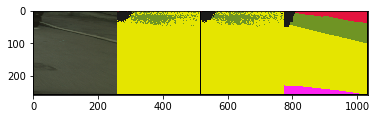

In [86]:
target_preds = torch.cat(target_preds_batch, dim=0).max(1)[1]
target_labels = torch.cat(target_labels_batch, dim=0)
target_images = torch.cat(target_images_batch, dim=0)
source_preds = torch.cat(source_preds_batch, dim=0).max(1)[1]



b = target_preds.size(0)
target_preds = target_preds.view(b, -1)
source_preds = source_preds.view(b, -1)
target_labels = target_labels.view(b, -1)
for i, (source_pred, target_pred, label, image) in enumerate(zip(source_preds, target_preds, target_labels, target_images)):
    adabn_iou = jaccard_score(target_pred, label, labels=all_labels, average=None)[1:].mean()
    iou = jaccard_score(source_pred, label, labels=all_labels, average=None)[1:].mean()

    if adabn_iou > iou:
        target_mask = colorize_mask(target_pred.view(256, 256))
        source_mask = colorize_mask(source_pred.view(256, 256))
        label = colorize_mask(label.view(256, 256))
        image = denormalize(image)
        imshow(vutils.make_grid(torch.cat([image.unsqueeze(0), source_mask.unsqueeze(0), target_mask.unsqueeze(0), label.unsqueeze(0)], dim=0), normalize=True))
        plt.show()

In [80]:
target_preds.shape

torch.Size([196, 65536])

In [55]:
all_labels = [i for i in range(34)]
from sklearn.metrics import jaccard_score
iou = jaccard_score(target_preds.view(-1).cpu().numpy(), target_labels.view(-1).cpu().numpy(), labels=all_labels, average=None).mean()

In [56]:
iou

0.06474855500966703